# Learn with Linear Model

Use a linear model to learn weights for draco. 

In [16]:
from draco.learn import linear
from draco.learn import data_util
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data, _ = data_util.load_data(test_size=0.3)

In [3]:
# limit task
# data.task.hist()
# data= data[data.task == 'derived']

## Run Model and then PCA

We see 7 distinct clusters. What do they mean?

Train score:  0.8311793214862682


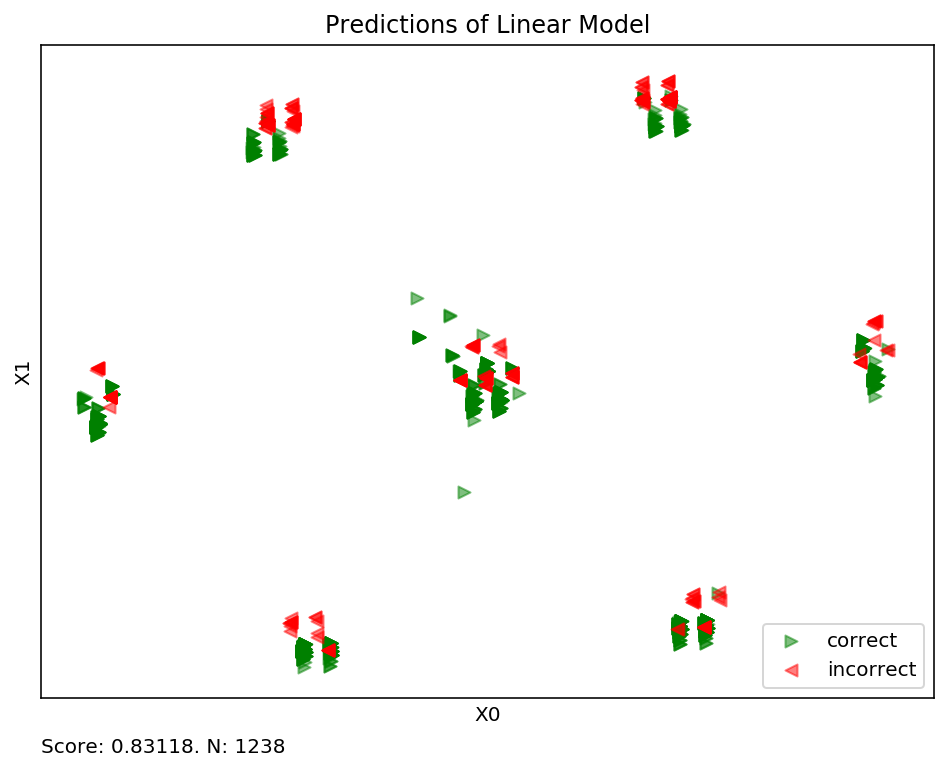

CPU times: user 923 ms, sys: 105 ms, total: 1.03 s
Wall time: 1.07 s


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [4]:
%time linear.train_and_plot(data, test_size=0)

## Explain Variance

Try to explain the variance using principal components. It we can explain most of the variance with few components, then the clustering we see above should be meaningful. 

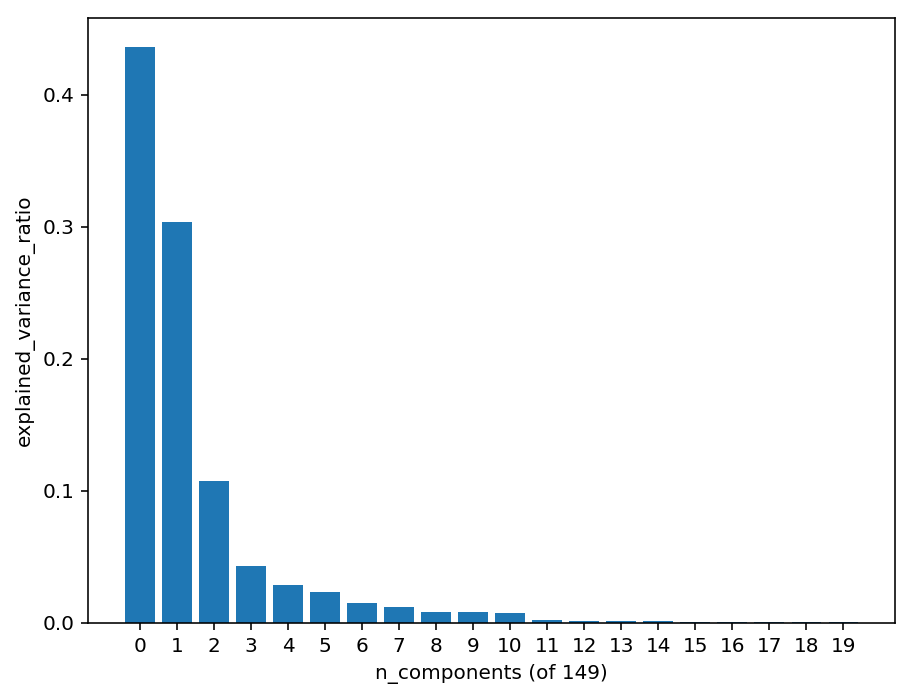

In [5]:
X = data.positive - data.negative

pca = PCA()
X2 = pca.fit_transform(X)

num_features = len(X.columns)
size = 20  # num_features

x = np.arange(size)

plt.figure(figsize=(8,6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.bar(x=x, height=pca.explained_variance_ratio_[:size])
plt.axis('tight')
plt.xlabel(f'n_components (of {num_features})')
plt.ylabel('explained_variance_ratio')
plt.xticks(x)

plt.show()

## Model score to accuracy

In [6]:
clf = linear.train_model(X, 0)

Train score:  0.8311793214862682


In [7]:
df = pd.DataFrame(columns=['pred', 'score'], index=X.index)

df.pred = clf.predict(X)
df.score = clf.decision_function(X)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118e23860>,
      dtype=object)

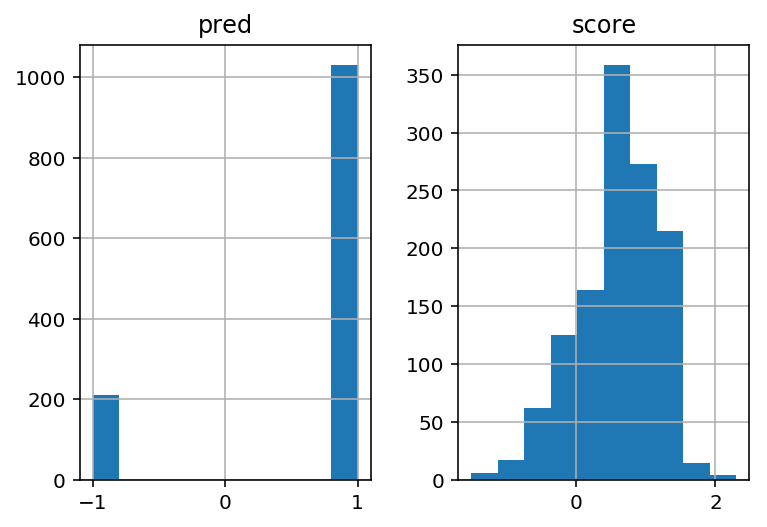

In [8]:
df.hist()

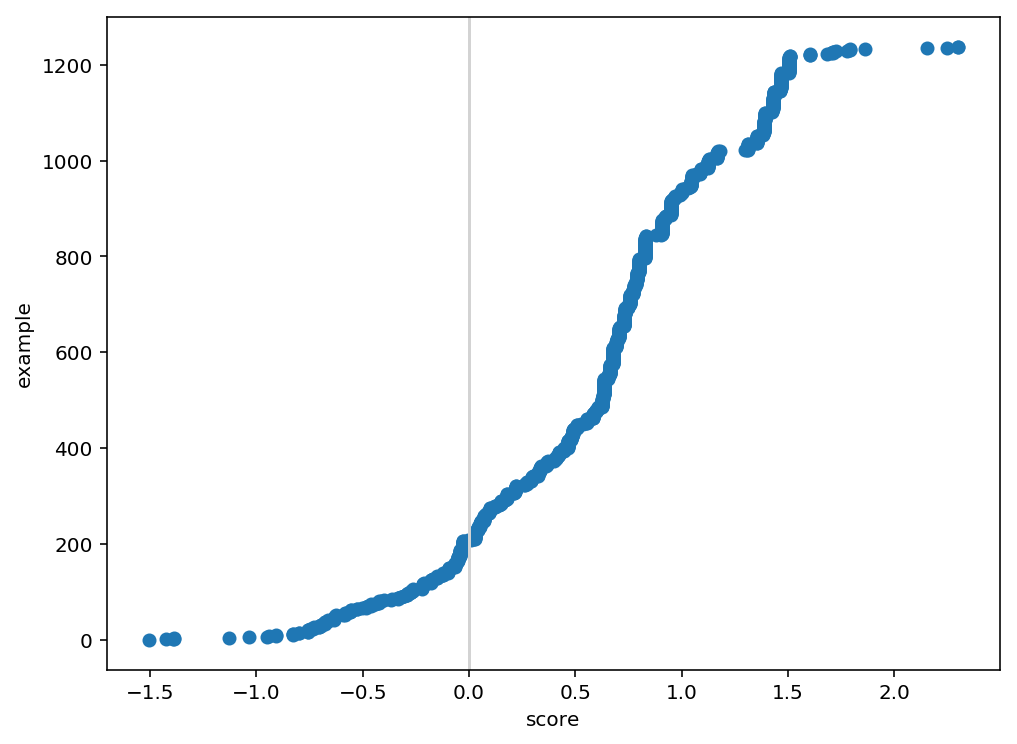

In [9]:
sorted_df = df.sort_values('score')
sorted_df = sorted_df.reset_index();

plt.figure(figsize=(8,6))
plt.scatter(x=sorted_df.score, y=sorted_df.index)
plt.xlabel('score')
plt.ylabel('example')
plt.axvline(0, color='lightgrey')

Text(0,0.5,'prediction')

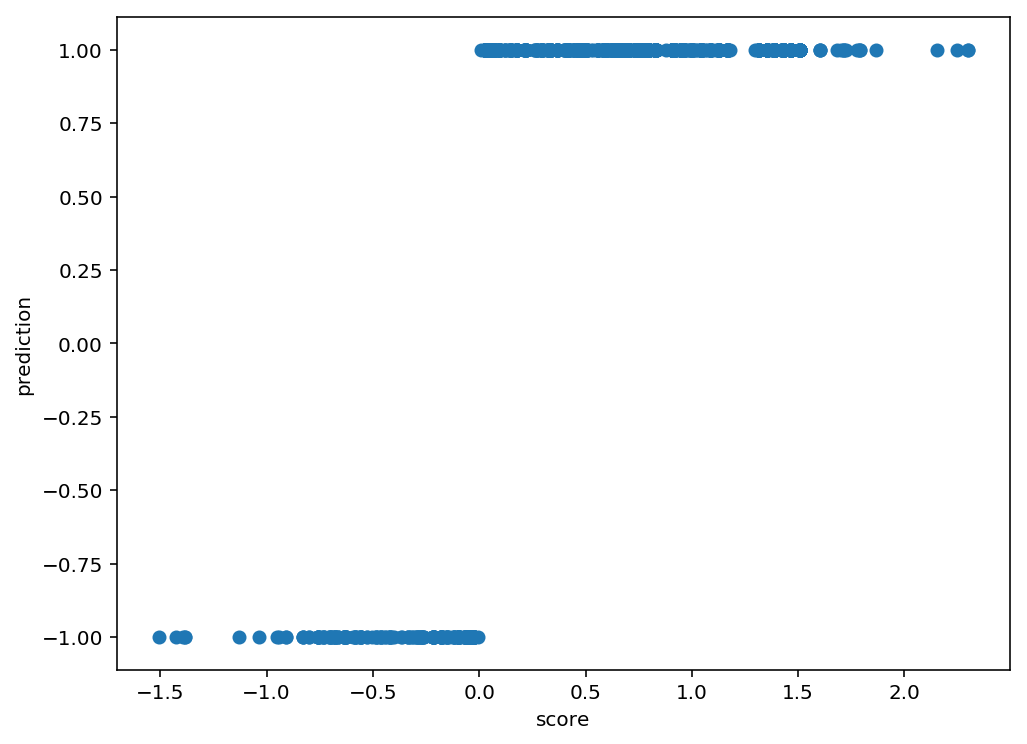

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(x=df.score, y=df.pred)
plt.xlabel('score')
plt.ylabel('prediction')

/usr/local/anaconda3/envs/asp/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Text(0,0.5,'label/loss')

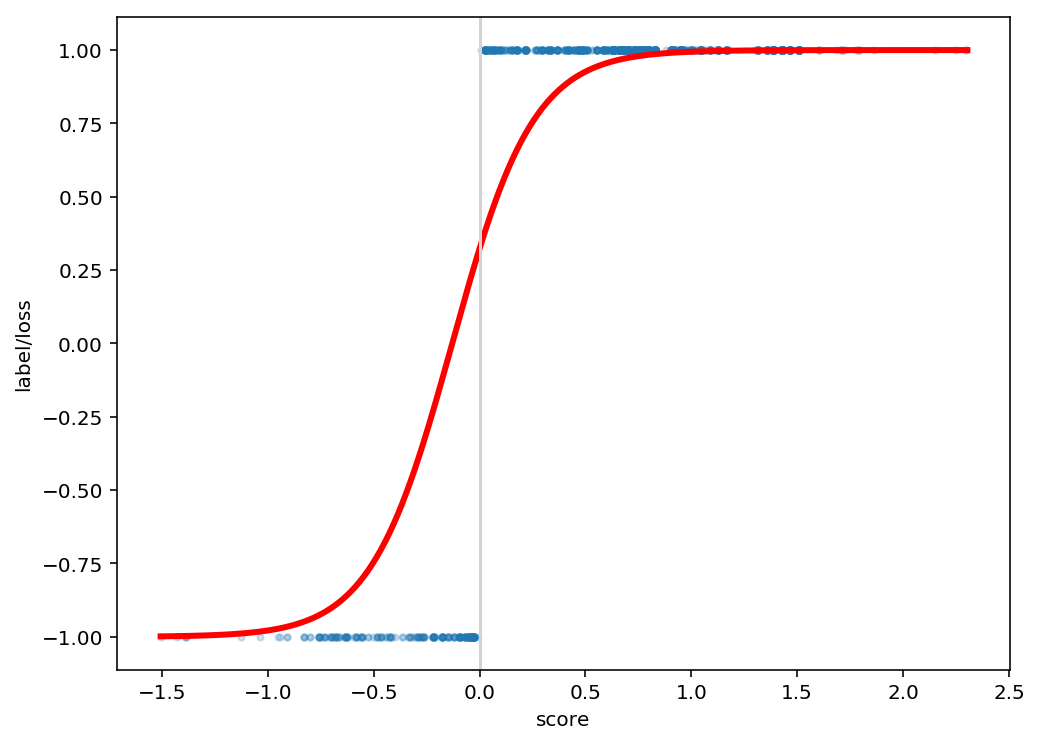

In [11]:
from sklearn.linear_model import LogisticRegression

score = df.pred.values.reshape(len(df.score), 1)
pred = df.pred.values.reshape(len(df.pred), 1)

logreg = LogisticRegression()
logreg.fit(X=score, y=pred)

resolution = 0.01
score_sample = np.arange(df.score.min(), df.score.max()+resolution, resolution)

def model(x):
    return 2 / (1 + np.exp(-x)) - 1
loss = model(score_sample * logreg.coef_ + logreg.intercept_).ravel()

plt.figure(figsize=(8,6))
plt.plot(score_sample, loss, color='red', linewidth=3)
plt.scatter(x=df.score, y=df.pred, alpha=0.2, s=10)
plt.axvline(0, color='lightgrey')
plt.xlabel('score')
plt.ylabel('label/loss')

## Explain the wrong predictions

In [12]:
df['task'] = data.task
df['source'] = data.source

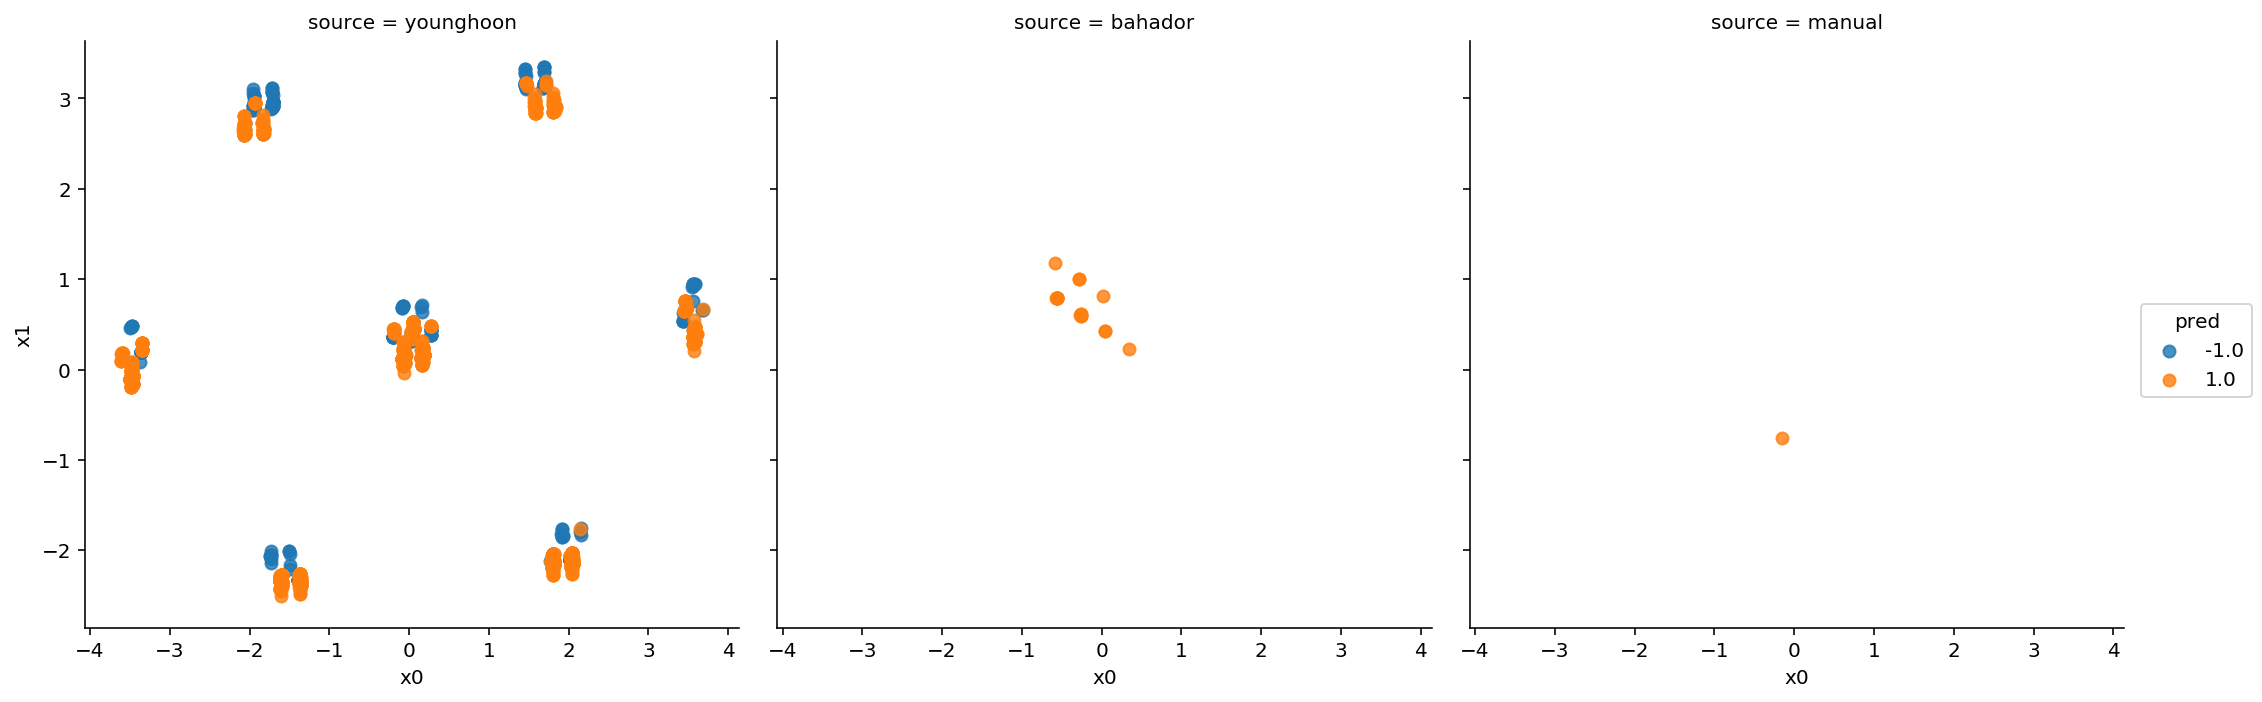

In [13]:
pca = PCA(2)
pca_df = pd.DataFrame(pca.fit_transform(X), index=X.index, columns=['x0', 'x1'])
pca_df = pd.concat([pca_df, df], axis=1)

sns.lmplot(x='x0', y='x1', hue='pred', col='source', data=pca_df, fit_reg=False)

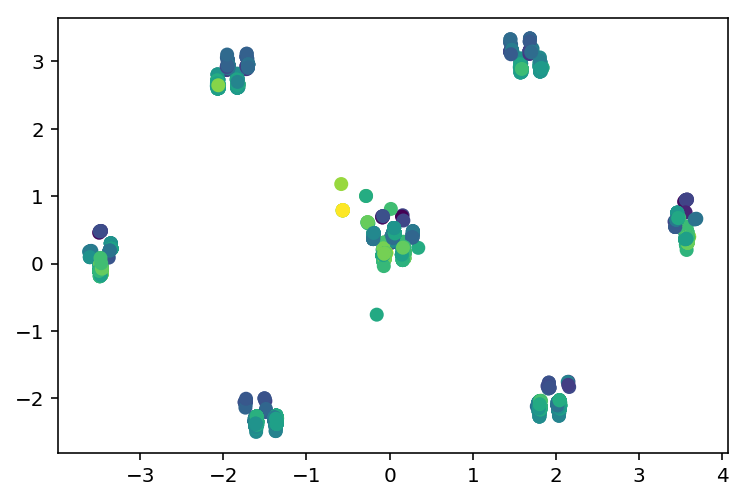

In [14]:
plt.scatter(x=pca_df.x0, y=pca_df.x1, c=pca_df.score, data=pca_df)

## Feature ranking

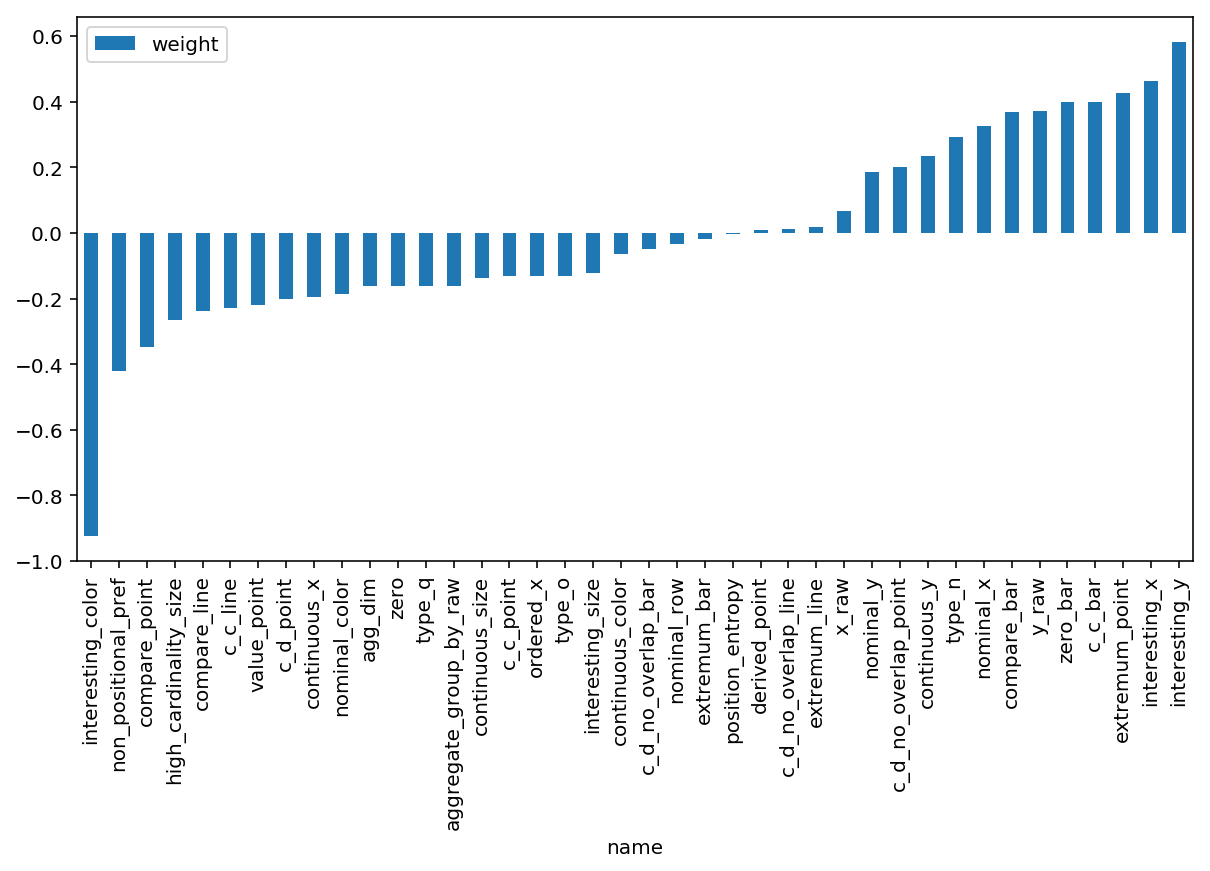

In [15]:
feat_df = pd.DataFrame({'name': X.columns, 'weight': clf.coef_[0]})
interesting_feat_df = feat_df[feat_df.weight != 0].sort_values('weight')
interesting_feat_df.plot.bar(x='name', figsize=(10, 5))